In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("vocal_gender_features_new.csv")

print(df.shape)


(16148, 44)


In [2]:
df.drop_duplicates(inplace=True)


In [4]:
X = df.drop("label", axis=1)
y = df["label"]   


In [22]:
selected_features = [
    "mfcc_5_mean",
    "mean_spectral_contrast",
    "mfcc_3_std",
    "mfcc_2_mean",
    "std_spectral_bandwidth",
    "mfcc_12_mean",
    "mfcc_1_mean",
    "mfcc_2_std",
    "mfcc_10_mean",
    "rms_energy",
    "mfcc_10_std",
    "mfcc_6_mean",
    "mfcc_8_mean",
    "mfcc_4_mean",
    "mfcc_13_mean",
    "mfcc_7_mean",
    "mfcc_3_mean",
    "mfcc_8_std",
    "mfcc_11_mean",
    "mfcc_5_std"
]

X_cluster = X[selected_features]


In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)


k means

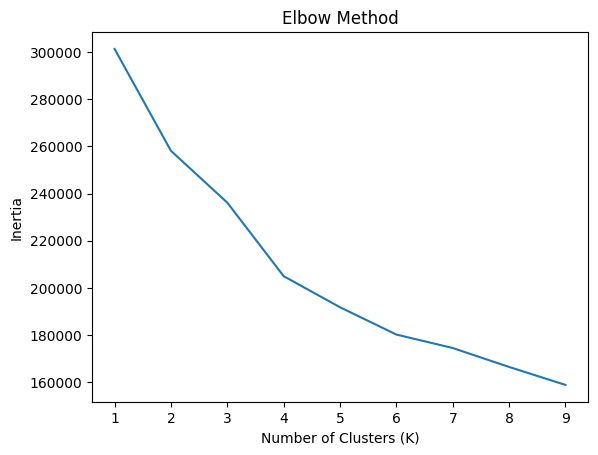

In [24]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,10), inertia)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


In [34]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

df["KMeans_Cluster"] = kmeans_labels


In [35]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, kmeans_labels)
print("Silhouette Score:", score)


Silhouette Score: 0.14032431051854583


In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X_pca)

from sklearn.metrics import silhouette_score
print("New Silhouette:", silhouette_score(X_pca, labels))


New Silhouette: 0.43609060950756284


In [37]:
for n in [2, 3, 5, 10, 15]:
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_scaled)
    
    kmeans = KMeans(n_clusters=2, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    
    score = silhouette_score(X_pca, labels)
    print(f"PCA components: {n} → Silhouette: {score}")


PCA components: 2 → Silhouette: 0.43609060950756284
PCA components: 3 → Silhouette: 0.3023650541916298
PCA components: 5 → Silhouette: 0.22511027139903197
PCA components: 10 → Silhouette: 0.203239682944412
PCA components: 15 → Silhouette: 0.17476590943178796


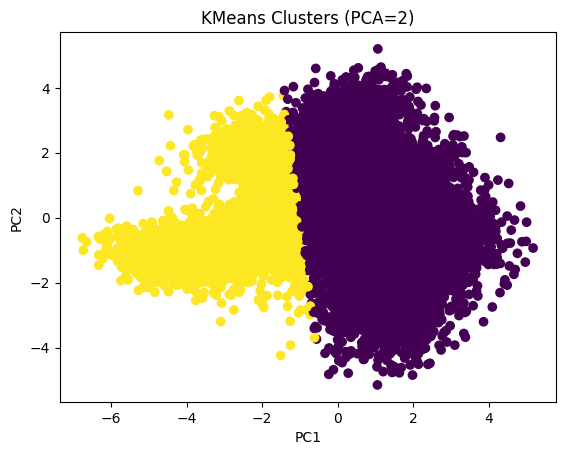

In [38]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X_pca)

plt.scatter(X_pca[:,0], X_pca[:,1], c=labels)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters (PCA=2)")
plt.show()


yellow:male purple:female

One gender forms a strong distinct cluster
The other overlaps more.

PCA + KMeans clustering revealed that one cluster predominantly contains male samples, while female samples are more distributed and overlap with males. This indicates partial natural grouping based on gender but not perfect separation.

In [39]:
pd.crosstab(df["label"], labels)


col_0,0,1
label,,
0,5178,51
1,6160,3681


dbscan

In [16]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=10, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

df["DBSCAN_Cluster"] = dbscan_labels


In [17]:
silhouette_score(X_scaled, dbscan_labels)


0.6587194619751262

In [18]:
import numpy as np

print("Unique cluster labels:", np.unique(dbscan_labels))
print("Cluster counts:\n", pd.Series(dbscan_labels).value_counts())


Unique cluster labels: [-1  0]
Cluster counts:
  0    15067
-1        3
Name: count, dtype: int64


DBSCAN grouped almost all voice samples into a single dense cluster, indicating that the feature space does not contain distinct density-separated regions. Only 3 samples were identified as noise.

In [42]:
import joblib

joblib.dump(pca, "models/pca.pkl")
joblib.dump(kmeans, "models/kmeans.pkl")


['models/kmeans.pkl']